In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import mutual_info_score, mean_squared_error
from sklearn.feature_extraction import DictVectorizer

%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams["figure.figsize"] = (13, 9) 

In [2]:
df = pd.read_csv("data/housing.csv")
df.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY


In [3]:
set(df.columns.values).difference(['latitude',
'longitude',
'housing_median_age',
'total_rooms',
'total_bedrooms',
'population',
'households',
'median_income',
'median_house_value',
'ocean_proximity'])

set()

In [4]:
df.fillna(0, inplace=True)

In [5]:
assert np.all(df.households) == True
df["rooms_per_household"] = df.total_rooms / df.households
df["bedrooms_per_household"] = df.total_bedrooms / df.households
df["population_per_household"] = df.population / df.households

---
### Question 1

What is the most frequent observation (mode) for the column `ocean_proximity`?

Options:
* `NEAR BAY`
* `<1H OCEAN`
* `INLAND`
* `NEAR OCEAN`

---

In [6]:
print(df.ocean_proximity.mode())

0    <1H OCEAN
Name: ocean_proximity, dtype: object


In [7]:
# We can see categorical feature stats using include="all" or include="object" parameter.
df.describe(include="object")

,ocean_proximity
count,20640
unique,5
top,<1H OCEAN
freq,9136


---
Split your data in train/val/test sets, with 60%/20%/20% distribution.
Use Scikit-Learn for that (the train_test_split function) and set the seed to 42.
Make sure that the target value (median_house_value) is not in your dataframe.

---

---
### Question 2

* Create the [correlation matrix](https://www.google.com/search?q=correlation+matrix) for the numerical features of your train dataset.
    - In a correlation matrix, you compute the correlation coefficient between every pair of features in the dataset.
* What are the two features that have the biggest correlation in this dataset?

Options:
* `total_bedrooms` and `households`
* `total_bedrooms` and `total_rooms`
* `population` and `households`
* `population_per_household` and `total_rooms`

---

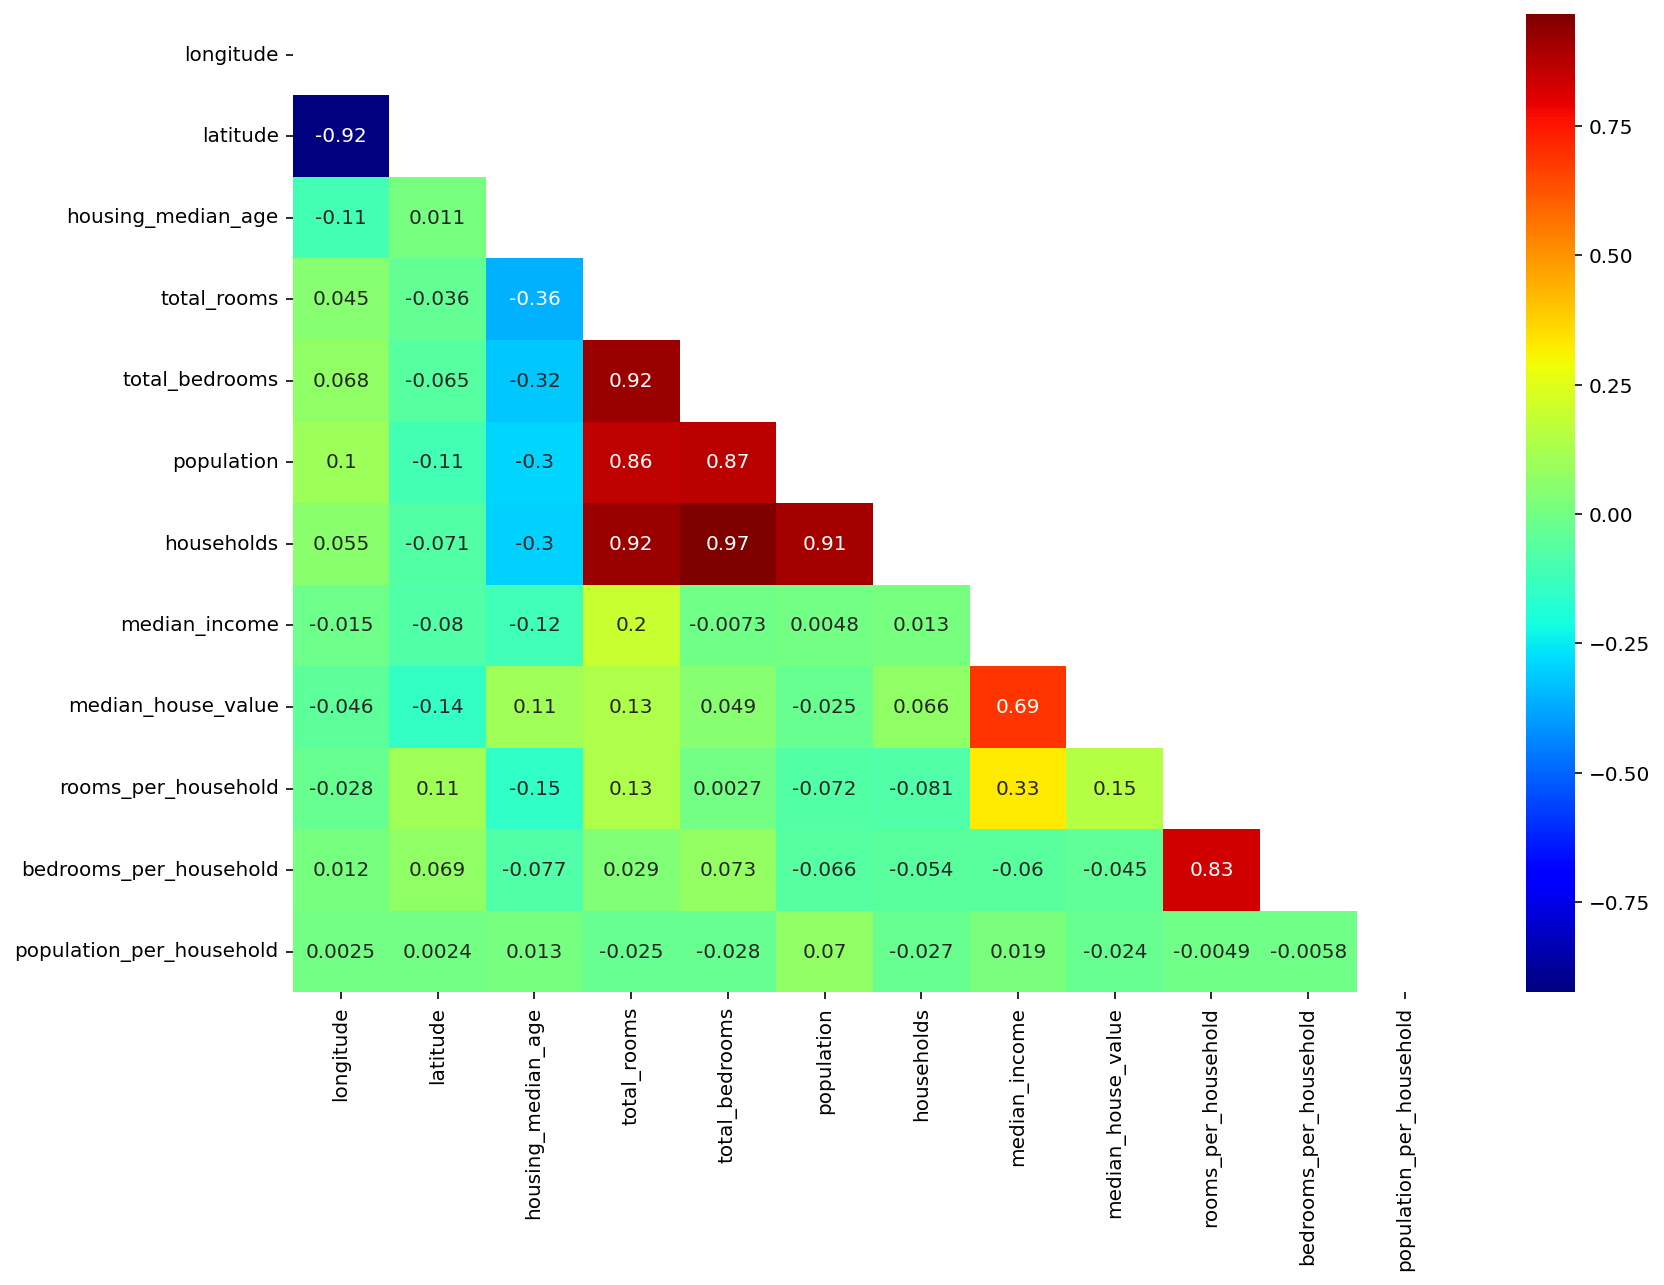

In [8]:
# Create a mask with numpy that fills upper triangle with 1s (k should be preferably 0, or 1 to see autocorrelation)
mask = np.triu(np.ones_like(df.corr()), k=0)
# Correlation heatmap without the duplicates
dataplot = sns.heatmap(df.corr(), cmap="jet", annot=True, mask=mask)
# Display the heatmap
plt.show()

In [9]:
y = df["median_house_value"]
df_feats = df.drop(["median_house_value"], axis=1)
df_feats.head()
df_full_train, df_test, y_full_train, y_test = train_test_split(df_feats, y , test_size= 0.2, random_state=42)
df_train, df_valid, y_train, y_valid = train_test_split(df_full_train, y_full_train , test_size= 0.25, random_state=42)

df_train.reset_index(drop=True, inplace=True)
df_valid.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [10]:
above_average = (y > y.mean()).astype(int)
above_average.mean()

0.40625

---
### Question 3

* Calculate the mutual information score with the (binarized) price for the categorical variable that we have. Use the training set only.
* What is the value of mutual information?
* Round it to 2 decimal digits using `round(score, 2)`

Options:
- 0.26
- 0
- 0.10
- 0.16
---

In [11]:
list(df_train.columns[df_train.dtypes == "object"])

['ocean_proximity']

In [12]:
# Training set using global mean.
y_train_binarized = (y_train > y.mean()).astype(int)
round(mutual_info_score(df_train.ocean_proximity, y_train_binarized), 3)

0.101

In [13]:
# Train + Validation using global mean.
y_full_train_binarized = (y_full_train > y.mean()).astype(int)
round(mutual_info_score(df_full_train.ocean_proximity, y_full_train_binarized), 3)

0.102

In [14]:
# Train + Validation using their mean.
y_full_train_binarized = (y_full_train > y_full_train.mean()).astype(int)
round(mutual_info_score(df_full_train.ocean_proximity, y_full_train_binarized), 3)

0.101

In [15]:
# Train using train set mean.
y_train_binarized = (y_train > y_train.mean()).astype(int)
round(mutual_info_score(df_train.ocean_proximity, y_train_binarized), 3)

0.101

As we can see above, using different mean values did not change the mutual information values for this dataset.

--- 
### Question 4

* Now let's train a logistic regression
* Remember that we have one categorical variable `ocean_proximity` in the data. Include it using one-hot encoding.
* Fit the model on the training dataset.
    - To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
    - `model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)`
* Calculate the accuracy on the validation dataset and round it to 2 decimal digits.

Options:
- 0.60
- 0.72
- 0.84
- 0.95
---

In [16]:
encoder = DictVectorizer(sparse=False)
records = df_train.to_dict(orient='records')
encoder.fit(records)

DictVectorizer(sparse=False)

In [17]:
X_train = encoder.transform(records)

In [18]:
X_valid = encoder.transform(df_valid.to_dict(orient='records'))

In [19]:
encoder.get_feature_names_out()

array(['bedrooms_per_household', 'households', 'housing_median_age',
       'latitude', 'longitude', 'median_income',
       'ocean_proximity=<1H OCEAN', 'ocean_proximity=INLAND',
       'ocean_proximity=ISLAND', 'ocean_proximity=NEAR BAY',
       'ocean_proximity=NEAR OCEAN', 'population',
       'population_per_household', 'rooms_per_household',
       'total_bedrooms', 'total_rooms'], dtype=object)

In [20]:
X_train.shape, X_valid.shape

((12384, 16), (4128, 16))

In [21]:
model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)

model.fit(X_train, y_train_binarized)
round(model.score(X_train, y_train_binarized), 2)

0.83

In [22]:
y_valid_binarized = (y_valid > y.mean()).astype(int)
round(model.score(X_valid, y_valid_binarized), 2)

0.84

In [23]:
acc_valid_all_features = model.score(X_valid, y_valid_binarized)

In [24]:
for col in ['total_rooms', 'total_bedrooms', 'population', 'households']:
    model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
    encoder = DictVectorizer(sparse=False)
    records = df_train.drop(columns=col, axis=1).to_dict(orient='records')
    X_train = encoder.fit_transform(records)
    X_valid = encoder.transform(df_valid.drop(columns=col, axis=1).to_dict(orient='records'))
    model.fit(X_train, y_train_binarized)
    acc_train = model.score(X_train, y_train_binarized)
    acc_valid = model.score(X_valid, y_valid_binarized)
    print(f"Column: {col} ")
    print("Train Accuracy %.4f" % acc_train)
    print("Valid Accuracy %.4f" % acc_valid)
    print("Valid Accuracy Difference %.4f" % abs(acc_valid_all_features - acc_valid))
    print("_________________________________")
    

Column: total_rooms 
Train Accuracy 0.8307
Valid Accuracy 0.8379
Valid Accuracy Difference 0.0019
_________________________________
Column: total_bedrooms 
Train Accuracy 0.8313
Valid Accuracy 0.8362
Valid Accuracy Difference 0.0002
_________________________________
Column: population 
Train Accuracy 0.8250
Valid Accuracy 0.8295
Valid Accuracy Difference 0.0065
_________________________________
Column: households 
Train Accuracy 0.8294
Valid Accuracy 0.8324
Valid Accuracy Difference 0.0036
_________________________________


Removing total bedrooms, the validation accuracy did not change up to 3 decimal digits.

---
### Question 6

* For this question, we'll see how to use a linear regression model from Scikit-Learn
* We'll need to use the original column `'median_house_value'`. Apply the logarithmic transformation to this column.
* Fit the Ridge regression model (`model = Ridge(alpha=a, solver="sag", random_state=42)`) on the training data.
* This model has a parameter `alpha`. Let's try the following values: `[0, 0.01, 0.1, 1, 10]`
* Which of these alphas leads to the best RMSE on the validation set? Round your RMSE scores to 3 decimal digits.

If there are multiple options, select the smallest `alpha`.

Options:
- 0
- 0.01
- 0.1
- 1
- 10
----

In [25]:
y_train_log = np.log1p(y_train)
y_valid_log = np.log1p(y_valid)
y_test_log = np.log1p(y_test)

In [26]:
alpha_params = [0, 0.01, 0.1, 1, 10]

encoder = DictVectorizer(sparse=False)
records = df_train.to_dict(orient='records')
X_train = encoder.fit_transform(records)
X_valid = encoder.transform(df_valid.to_dict(orient='records'))
X_test = encoder.transform(df_test.to_dict(orient='records'))

for a in alpha_params:
    model = Ridge(alpha=a, solver="sag", random_state=42)
    model.fit(X_train, y_train_log)
    rmse_train = np.sqrt(mean_squared_error(model.predict(X_train), y_train_log))
    rmse_valid = np.sqrt(mean_squared_error(model.predict(X_valid), y_valid_log))
    rmse_test = np.sqrt(mean_squared_error(model.predict(X_test), y_test_log))
    print(f"Alpha Value: {a} ")
    print("Train set RMSE %.7f" % rmse_train)
    print("Valid set RMSE %.7f" % rmse_valid)
    print("Test set RMSE %.7f" % rmse_test)
    print("_________________________________")
    

Alpha Value: 0 
Train set RMSE 0.5244350
Valid set RMSE 0.5240635
Test set RMSE 0.5660386
_________________________________
Alpha Value: 0.01 
Train set RMSE 0.5244350
Valid set RMSE 0.5240635
Test set RMSE 0.5660386
_________________________________
Alpha Value: 0.1 
Train set RMSE 0.5244350
Valid set RMSE 0.5240635
Test set RMSE 0.5660386
_________________________________
Alpha Value: 1 
Train set RMSE 0.5244350
Valid set RMSE 0.5240635
Test set RMSE 0.5660386
_________________________________
Alpha Value: 10 
Train set RMSE 0.5244350
Valid set RMSE 0.5240636
Test set RMSE 0.5660386
_________________________________


---
The end of the Week 3 assignment.

---